# Building RLHF with Personalized Datasets

Reinforcement Learning with Human Feedback (RLHF) is a widely used technique in natural language processing that focuses on optimizing language models according to human preferences, departing from conventional training methods like supervised or unsupervised learning. With the recent release of ChatGPT to the public, RLHF has gained significant attention in both academic and industrial language modeling communities.

This notebook will guide you through the process of implementing RLHF using the trlX library and creating a personalized dataset using Label Studio. By the end of this tutorial, you will have a solid grasp of how to apply RLHF with customized datasets, enabling you to delve deeper into this exciting research domain.

The notebook will be organized as follows:

1. Introduction to RLHF and trlX
2. Setting up the environment and installing necessary libraries
3. Crafting a customized dataset
4. Annotating our dataset using Label Studio
5. Training a preference model with our tailored dataset
6. Fine-tuning our language model with our preference model using trlX
Let's begin!

## 1. Introduction to RLHF and trlX

Implementing RLHF with custom datasets might seem challenging, especially for those not yet familiar with the required tools and techniques. The main goal of this notebook is to demonstrate a method for mitigating bias while fine-tuning Language Models (LLMs) using feedback from humans. To accomplish this, we'll use a concise set of tools, including Huggingface, GPT2, Label Studio, Weights and Biases, and trlX.

Our objective is to present the most effective and uncomplicated approach to establish a pipeline that goes from raw data to a practical RLHF system. We'll go through the process step by step, covering an introduction to RLHF and trlX, setting up the environment, creating a custom dataset, annotating our dataset with Label Studio, training a preference model with our tailored dataset, and finally, fine-tuning our language model with our preference model using trlX.

The Training Approach for RLHF is as follows ([source](https://arxiv.org/pdf/2009.01325.pdf)):
1. Gather human feedback
2. Develop a reward model
3. Optimize the LLM based on the reward model.

## 2. Setting up the environment and installing necessary libraries

In [1]:
!pip install -q git+https://github.com/CarperAI/trlx

# uninstall scikit_learn + jax to avoid numpy issues
!pip uninstall -y scikit_learn jax

!pip install -q mpi4py pyngrok

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.3/867.3 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB

## 3. Creating a Custom Dataset

In this section, our goal is to generate a custom dataset for training our reward model. When fine-tuning a Language Model (LLM) for human preference, the data typically takes the following format:

```json
{
    "prompt": "The quick brown fox...",
    "answer1": "jumps over the lazy dog.",
    "answer2": "bags few lynx.",
}
```

The labeler assesses and provides feedback on which option is preferred, based on the given prompt. This human feedback becomes an integral part of the system. Through this ranking process by human labelers, we can train a model to evaluate the quality of responses generated by our language model.

In this example, we'll guide you on how to create your own dataset. We'll commence with a set of prompts, generate predictions for them using GPT-2, and then have users rank the generated predictions.

Please note: Due to the computational limitations of Colab, we'll be utilizing GPT-2 for this notebook. Consequently, the quality of our predictions may not be as high. If you have access to more powerful hardware, you can substitute the GPT-2 model with a larger one like [GPT-J](https://huggingface.co/EleutherAI/gpt-j-6b) or others for better results.

In [2]:
from transformers import pipeline, set_seed
import json

def generate_examples(prompt_list, model_name='gpt2', max_length=50, num_return_sequences=2, seed=42):
    """
    Generates examples of text based on a list of prompts using a specified model.

    Args:
        prompt_list (list): List of prompts for text generation.
        model_name (str): Name of the model to use for text generation (default is 'gpt2').
        max_length (int): Maximum length of generated text (default is 50).
        num_return_sequences (int): Number of sequences to generate for each prompt (default is 2).
        seed (int): Seed for random number generation (default is 42).

    Returns:
        list: List of generated examples, each containing the prompt and generated answers.
    """
    # Initialize a text generation pipeline with the specified model
    generator = pipeline('text-generation', model=model_name, device=0)

    # Set seed for reproducibility
    set_seed(seed)

    # List to store generated examples
    examples = []

    for prompt in prompt_list:
        # Generate text based on the prompt
        result = generator(prompt, max_length=max_length, num_return_sequences=num_return_sequences)

        # Create a dictionary to store the example
        example = {'prompt': prompt}

        for i, res in enumerate(result):
            # Extract the generated answer and add it to the example
            answer = res['generated_text'].lstrip().removeprefix(prompt).strip()
            example[f'answer{i + 1}'] = answer

        # Add the example to the list
        examples.append(example)

        # Print the example as JSON with indentation for visualization
        print(json.dumps(example, indent=2))

    return examples

In [3]:
prompts = [
  "What is the use of Statistics in Data Science? ",
  "What is the difference between Supervised Learning and Unsupervised Learning? ",
  "What is a Linear Regression? ",
  "What is Logistic Regression? ",
  "Explain Normal Distribution. ",
  "Mention some drawbacks of the Linear Model.",
]

In [4]:
generated_examples = generate_examples(prompts)

# Save generated examples to import in Label Studio
with open('ls_input_data.json', 'w') as f:
    json.dump(generated_examples, f, indent=2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
  "prompt": "What is the use of Statistics in Data Science? ",
  "answer1": "How can you learn something better than statistics? \u00a0No, statistics have not been invented yet, but statistics are the first approximation, and this one is what is most interesting. In Computer",
  "answer2": "It is important to distinguish between an actual method and an imagined method of thinking through data. \u00a0Any method will be capable of being analyzed and analysed with minimal effort. \u00a0Any approach"
}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
  "prompt": "What is the difference between Supervised Learning and Unsupervised Learning? ",
  "answer1": "I was wondering if you could share an open question on that topic about how you think about the effects of adversarial video teaching. \u00a0I know you already did that",
  "answer2": "In both cases, I would argue that supervised learning is more expensive and less reliable to execute than unbounded, unbounded or unsupervised learning, as this \"un"
}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
  "prompt": "What is a Linear Regression? ",
  "answer1": "A common way in many fields to show that your performance has improved is by presenting a fixed-length column, with a value of 10. In Figure 1.8, I have only given this variable a",
  "answer2": "I have worked on this topic for several years so, what if I made a single dataset and applied it to the same data set but could not find a way to use every value of 'logic'"
}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
  "prompt": "What is Logistic Regression? ",
  "answer1": "In both cases, you must use a subset of the current model, to prove the regression model.\nBut what is the real purpose of a regression? \u00a0It is to estimate the magnitude of a",
  "answer2": "We are here to show that when you look at graphs in Logistic Regression, you might sometimes catch the difference between a low-order approximation and a good linear regression. In fact, we look to"
}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{
  "prompt": "Explain Normal Distribution. ",
  "answer1": "********* BEGIN AS IS: * Determine Normalization, Determinance, and Purity of Distributions. * * Determine Normalization for Single-Dimensional Distributions. In each D, *",
  "answer2": "___________ * \\|_\\|\\|\\|_ / \\|_\\| / _ \\|__ / \\|_ / _ / \\|_ / _ _ \\|_ / \\|"
}
{
  "prompt": "Mention some drawbacks of the Linear Model.",
  "answer1": "It comes up about two per year. We assume that the average household is in college, with an average college-based income of $55,000 compared to $75,000 for an adult.",
  "answer2": "For instance, the model is very much biased, so it is more useful to try to find some patterns in it that don't fit very well. For instance, if a person's parents are involved,"
}


# 4. Labeling our dataset with Label Studio

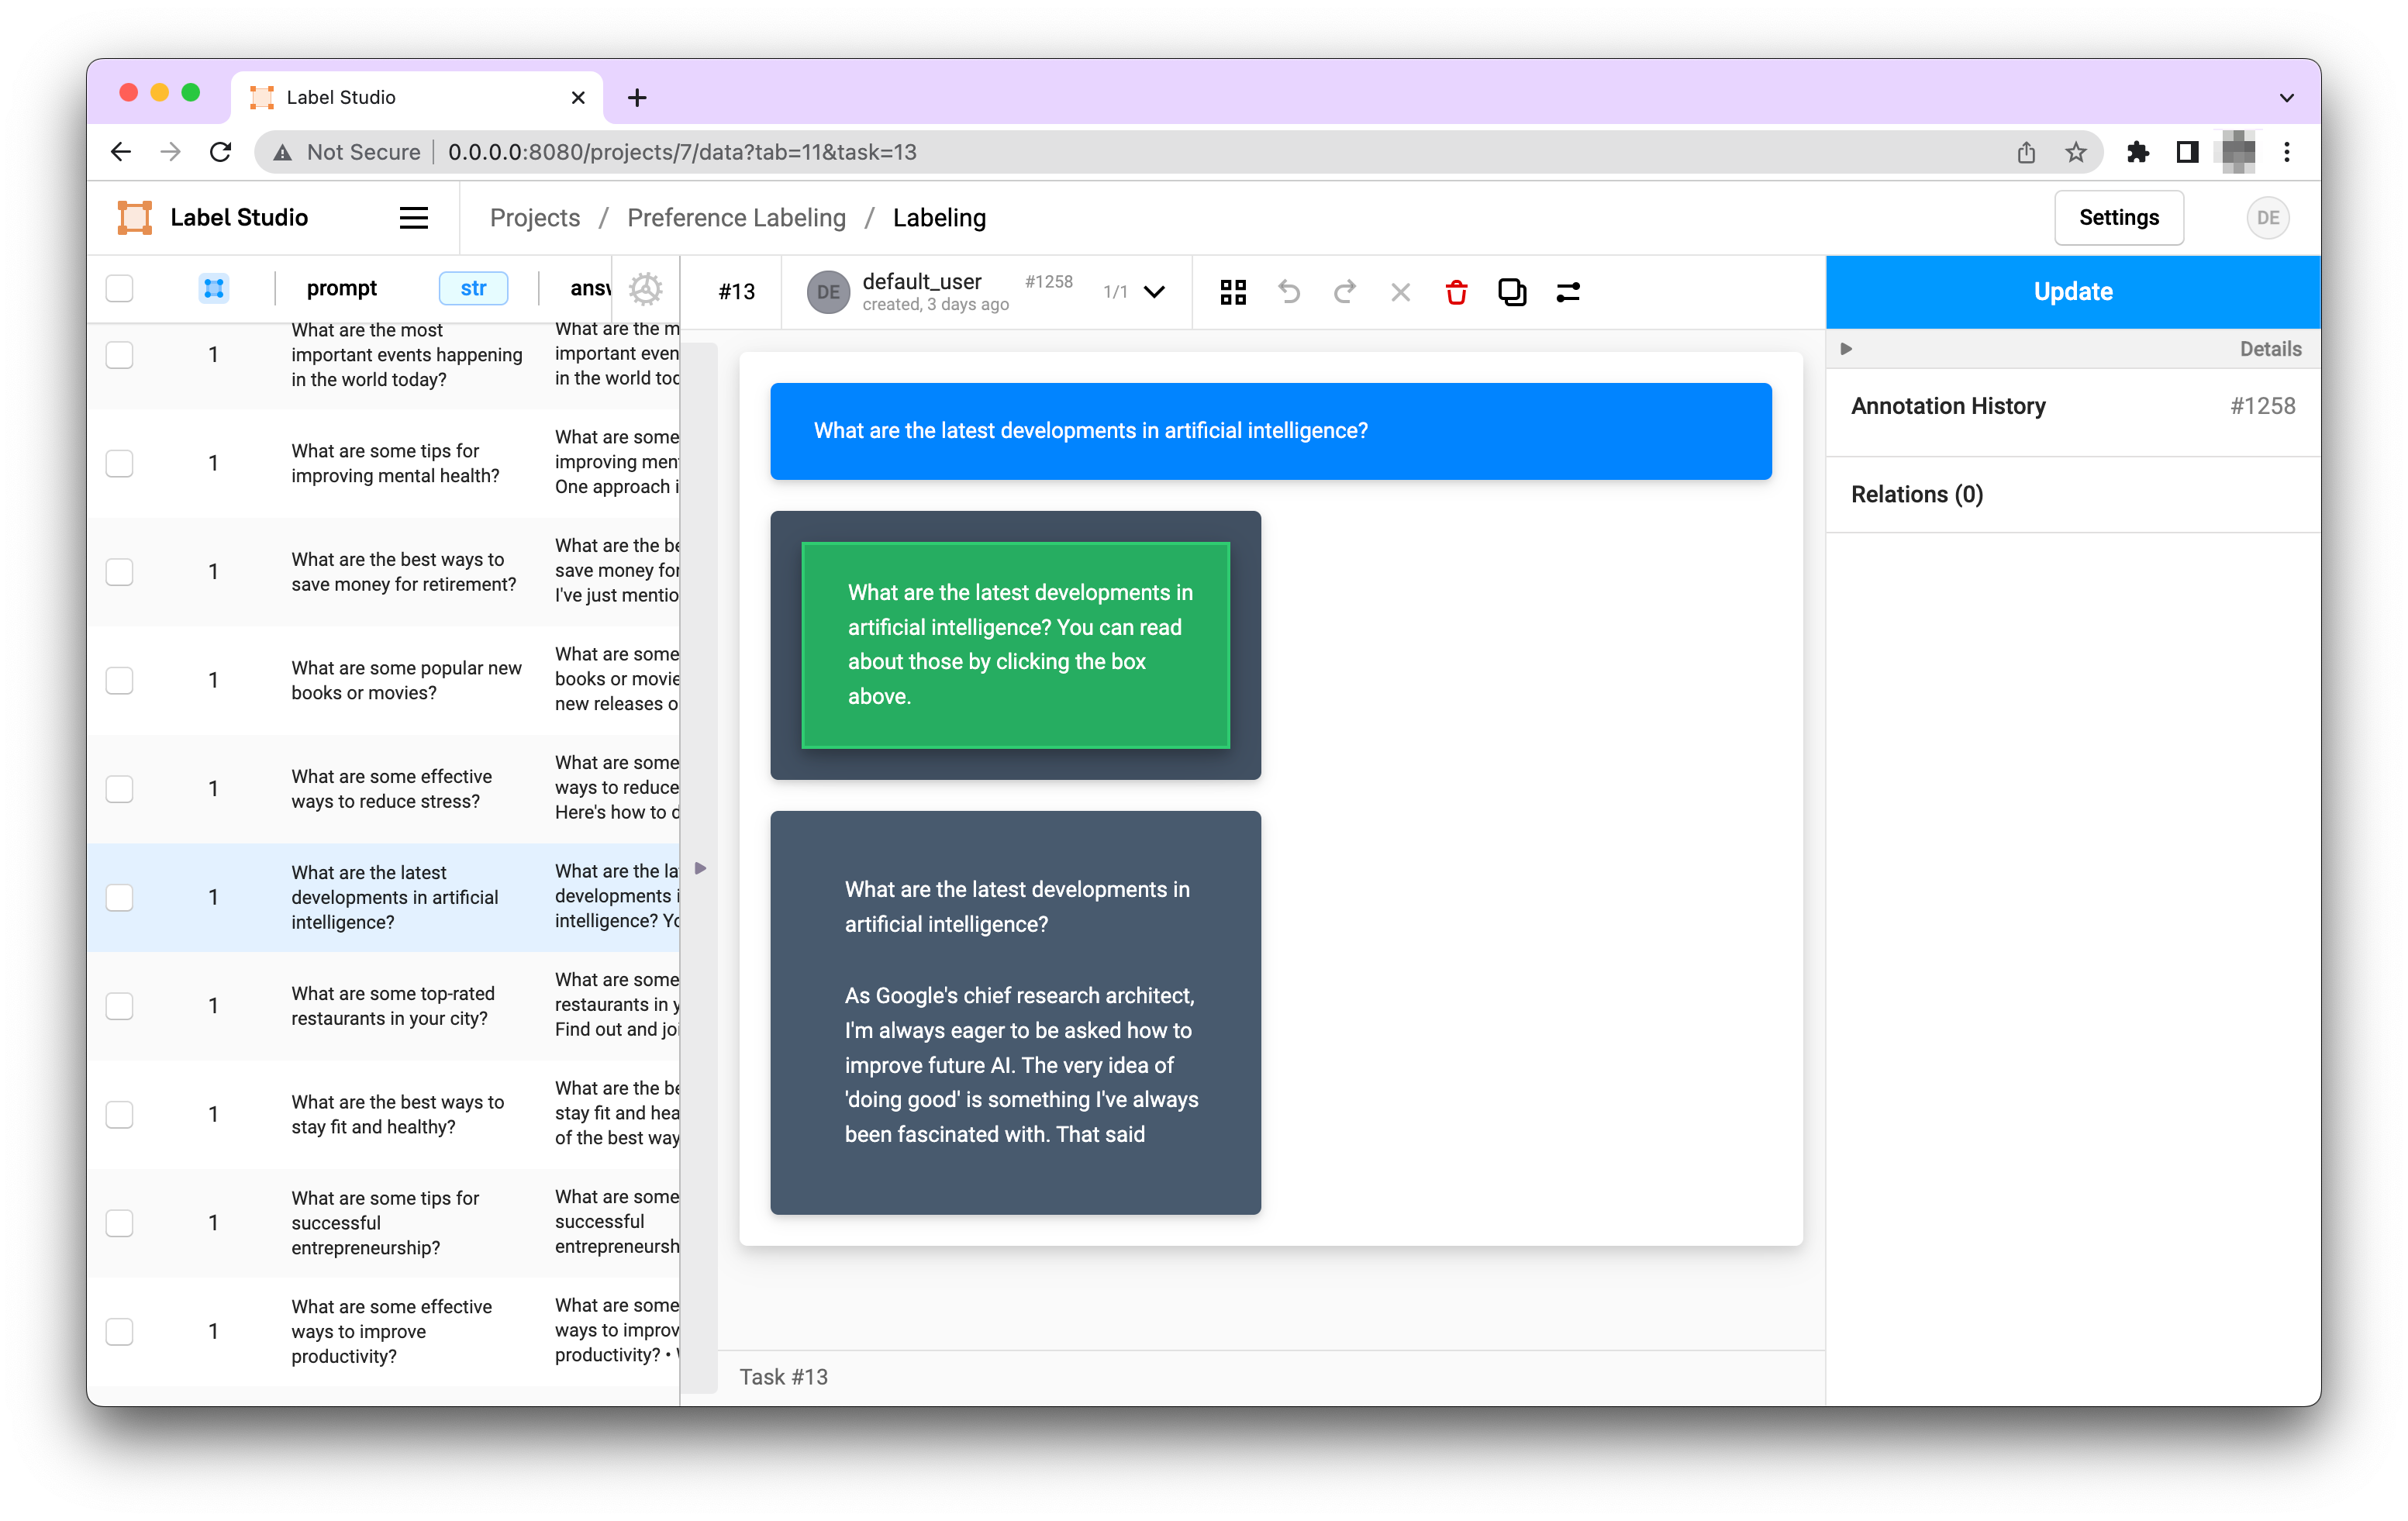

Now that we have generated some examples, we will label them in Label Studio.
Once we have the results of our human labels, we can export the data and train our Preference Model.

1. Log in to the Label Studio

2. Once we have label studio running, we can create a new project with the [Pariwise Classification template](https://labelstud.io/templates/pairwise_comparison.html):

```xml
<View>
   <Style>* { box-sizing: border-box; margin: 0; padding: 0; } body { font-family: 'Roboto', sans-serif; line-height: 1.6; background-color: #f0f0f0; } .container { margin: 0 auto; padding: 20px; background-color: #ffffff; border-radius: 5px; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.1), 0 6px 20px 0 rgba(0, 0, 0, 0.1); } .prompt { padding: 20px; background-color: #0084ff; color: #ffffff; border-radius: 5px; margin-bottom: 20px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1), 0 3px 10px 0 rgba(0, 0, 0, 0.1); } .answers { display: flex; justify-content: space-between; flex-wrap: wrap; gap: 20px; } .answer-box { flex-basis: 49%; padding: 20px; background-color: rgba(44, 62, 80, 0.9); color: #ffffff; border-radius: 5px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1), 0 3px 10px 0 rgba(0, 0, 0, 0.1); } .answer-box p { word-wrap: break-word; } .answer-box:hover { background-color: rgba(52, 73, 94, 0.9); cursor: pointer; transition: all 0.3s ease; } .lsf-richtext__line:hover { background: unset; } .answer-box .lsf-object { padding: 20px }</Style>
   <View className="container">
      <View className="prompt">
         <Text name="prompt" value="$prompt" />
      </View>
      <View className="answers">
         <Pairwise name="pw" toName="answer1,answer2" selectionStyle="background-color: #27ae60; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.2), 0 6px 20px 0 rgba(0, 0, 0, 0.2); border: 2px solid #2ecc71; cursor: pointer; transition: all 0.3s ease;" />
         <View className="answer-box">
            <Text name="answer1" value="$answer1" />
         </View>
         <View className="answer-box">
            <Text name="answer2" value="$answer2" />
         </View>
      </View>
   </View>
</View>
```

3. Next we'll drag and drop to upload our data, and we're off!

4. Once we're finished labeling our data, we can export it and we're ready to train our preference model.

Note: If you're using colab, upload the dataset into the root directory, and your file will be located at a path in `/content/...`, like `/content/project-....json`. Be sure to save the file as regular json format.

In [5]:
username = "ivan@localhost"
password = "pydata123"

%env LABEL_STUDIO_USERNAME={username}
%env LABEL_STUDIO_PASSWORD={password}

env: LABEL_STUDIO_USERNAME=ivan@localhost
env: LABEL_STUDIO_PASSWORD=pydata123


In [6]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [7]:
import os
import getpass

from pyngrok import ngrok

# Define the path for the ngrok config file
config_file = ngrok.conf.DEFAULT_NGROK_CONFIG_PATH

# Check if the config file already exists
config_file_exists =  os.path.exists(config_file)

# Read the contents of the config file
config_file_contents = !cat {config_file}

# Check if an auth token is already present in the config file
auth_token_found = config_file_exists \
    and config_file_contents \
    and "authtoken" in config_file_contents[0] \
    and ": exit" not in config_file_contents  # Check if the process was interrupted

# If an auth token is not found, prompt the user to enter it
if not auth_token_found:
    print("Enter your ngrok auth token, which can be copied from https://dashboard.ngrok.com/auth")

    # Use getpass to securely input the ngrok auth token
    !ngrok authtoken {getpass.getpass()}

Enter your ngrok auth token, which can be copied from https://dashboard.ngrok.com/auth
··········
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [8]:
LABEL_STUDIO_PORT = 8081
%env LABEL_STUDIO_PORT={LABEL_STUDIO_PORT}

https_tunnel = ngrok.connect(LABEL_STUDIO_PORT, bind_tls=True)
print(https_tunnel)

env: LABEL_STUDIO_PORT=8081


Exception in thread Thread-11 (_monitor_process):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pyngrok/process.py", line 146, in _monitor_process
    self._log_line(self.proc.stdout.readline())
  File "/usr/lib/python3.10/encodings/ascii.py", line 26, in decode
    return codecs.ascii_decode(input, self.errors)[0]
UnicodeDecodeError: 'ascii' codec can't decode byte 0xc2 in position 184: ordinal not in range(128)


NgrokTunnel: "https://ed82-34-90-235-90.ngrok-free.app" -> "http://localhost:8081"


In [9]:
!pip install -q label-studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.8/392.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.9/160.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.3/120.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.7 MB/s eta 0

In [10]:
print(https_tunnel.public_url)
print("u:", username)
print("p:", password)

https://ed82-34-90-235-90.ngrok-free.app
u: ivan@localhost
p: pydata123


In [11]:
!label-studio start --port=$LABEL_STUDIO_PORT

=> Database and media directory: /root/.local/share/label-studio
/root/.local/share/label-studio/.env not found - if you're not configuring your environment separately, check this.
get 'SECRET_KEY' casted as '<class 'str'>' with default ''
=> Static URL is set to: /static/
=> Database and media directory: /root/.local/share/label-studio
Read environment variables from: /root/.local/share/label-studio/.env
get 'SECRET_KEY' casted as '<class 'str'>' with default ''
=> Static URL is set to: /static/
[Tracing] Create new propagation context: {'trace_id': 'cff02b5063bb4392802ca5e5c00d3707', 'span_id': '89becb90dbbdb50e', 'parent_span_id': None, 'dynamic_sampling_context': None}
Starting new HTTPS connection (1): pypi.org:443
https://pypi.org:443 "GET /pypi/label-studio/json HTTP/1.1" 200 58131
Can't read version file: ls-version_.py. Fall back to: version_.py
[2023-09-16 02:34:36,773] [root::_read_py::61] [WARNING] Can't read version file: ls-version_.py. Fall back to: version_.py
Initializ

## 5. Training a preference model with our custom dataset
Now we're ready to train our preference model. We'll create a dataset from our labels, initialize our model from the pretrained LM, and then begin training.

When we finally train our model, we can connect with Weights and Biases to log our training metrics.

In [12]:
import codecs

# This file is generated by Label Studio after completing annotations
data_path = '/content/project-2-at-2023-09-15-23-52-0d07c439.json'

with codecs.open(data_path, 'r', encoding='utf-8') as f:
      data = json.load(f)
print(data)

[{'id': 33, 'annotations': [{'id': 4, 'completed_by': 2, 'result': [{'value': {'selected': 'right'}, 'id': 'nmJuiqIJih', 'from_name': 'pw', 'to_name': 'pw', 'type': 'pairwise', 'origin': 'manual'}], 'was_cancelled': False, 'ground_truth': False, 'created_at': '2023-09-15T23:51:21.175744Z', 'updated_at': '2023-09-15T23:51:21.175789Z', 'draft_created_at': None, 'lead_time': 10.96, 'prediction': {}, 'result_count': 0, 'unique_id': 'a81f1d01-fcfe-45ff-9d34-1212f37ef381', 'import_id': None, 'last_action': None, 'task': 33, 'project': 2, 'updated_by': 2, 'parent_prediction': None, 'parent_annotation': None, 'last_created_by': None}], 'file_upload': '4f6f82f5-ls_input_data_1.json', 'drafts': [], 'predictions': [], 'data': {'prompt': 'What is the use of Statistics in Data Science? ', 'answer1': 'How can you learn something better than statistics? \xa0No, statistics have not been invented yet, but statistics are the first approximation, and this one is what is most interesting. In Computer', 'a

In [13]:
import trlx

[2023-09-16 02:35:55,792] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [14]:
!git clone https://github.com/CarperAI/trlx.git

Cloning into 'trlx'...
remote: Enumerating objects: 8056, done.
remote: Counting objects: 100% (3333/3333), done.
remote: Compressing objects: 100% (751/751), done.
remote: Total 8056 (delta 2837), reused 2865 (delta 2580), pack-reused 4723
Receiving objects: 100% (8056/8056), 46.83 MiB | 23.56 MiB/s, done.
Resolving deltas: 100% (5543/5543), done.


In [15]:
os.chdir('/content/trlx/examples/summarize_rlhf/reward_model/')

In [16]:
import os
import torch
import codecs
import json
from datasets import load_dataset
from reward_model import GPTRewardModel
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers import AutoTokenizer, Trainer, TrainingArguments

def create_comparison_dataset_ls(data_path: str):
    """
    Create a comparison dataset from a JSON file.

    Args:
        data_path (str): Path to the JSON file.

    Returns:
        list: List of comparison pairs.
    """
    with codecs.open(data_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    pairs = []

    for sample in data:
        chosen = None
        rejected = None

        if "annotations" in sample:
            for annotation in sample['annotations']:
                if annotation['result'][0]['value']['selected'] == 'left':
                    chosen = sample['data']['prompt'] + '\n' + sample['data']['answer1']
                    rejected = sample['data']['prompt'] + '\n' + sample['data']['answer2']
                else:
                    chosen = sample['data']['prompt'] + '\n' + sample['data']['answer2']
                    rejected = sample['data']['prompt'] + '\n' + sample['data']['answer1']

                pair = {
                    'chosen': chosen,
                    'rejected': rejected
                }
                pairs.append(pair)

    return pairs

class PairwiseDataset(Dataset):
    """
    Dataset class for pairwise comparisons.
    """
    def __init__(self, pairs, tokenizer, max_length):
        """
        Initialize PairwiseDataset.

        Args:
            pairs (list): List of comparison pairs.
            tokenizer: The tokenizer for processing input data.
            max_length (int): Maximum length of generated text.
        """
        self.chosen_input_ids = []
        self.chosen_attn_masks = []
        self.rejected_input_ids = []
        self.rejected_attn_masks = []

        for pair in tqdm(pairs):
            chosen, rejected = pair["chosen"], pair["rejected"]
            chosen_encodings_dict = tokenizer(
                "" + chosen + "",
                truncation=True,
                max_length=max_length,
                padding="max_length",
                return_tensors="pt",
            )
            rejected_encodings_dict = tokenizer(
                "" + rejected + "",
                truncation=True,
                max_length=max_length,
                padding="max_length",
                return_tensors="pt",
            )
            self.chosen_input_ids.append(chosen_encodings_dict["input_ids"])
            self.chosen_attn_masks.append(chosen_encodings_dict["attention_mask"])
            self.rejected_input_ids.append(rejected_encodings_dict["input_ids"])
            self.rejected_attn_masks.append(rejected_encodings_dict["attention_mask"])

    def __len__(self):
        return len(self.chosen_input_ids)

    def __getitem__(self, idx):
        return (
            self.chosen_input_ids[idx],
            self.chosen_attn_masks[idx],
            self.rejected_input_ids[idx],
            self.rejected_attn_masks[idx],
        )


class DataCollatorReward:
    """
    Data collator for reward model training.
    """
    def __call__(self, data):
        """
        Call method for data collation.

        Args:
            data: List of data samples.

        Returns:
            dict: Batched data.
        """
        batch = {}
        batch["input_ids"] = torch.cat([f[0] for f in data] + [f[2] for f in data])
        batch["attention_mask"] = torch.cat([f[1] for f in data] + [f[3] for f in data])
        batch["labels"] = torch.tensor([0] * len(data) + [1] * len(data))
        return batch


def compute_metrics(eval_preds):
    """
    Compute evaluation metrics for the reward model.

    Args:
        eval_preds: Evaluation predictions.

    Returns:
        dict: Computed metrics.
    """
    chosen_end_scores = eval_preds.predictions[0]  # chosen scores
    rejected_end_scores = eval_preds.predictions[1]  # rejected scores

    result = {}
    acc = sum(chosen_end_scores > rejected_end_scores) / len(rejected_end_scores)
    result["accuracy"] = acc

    return result

In [17]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

if not os.path.exists("rm_checkpoint"):
    os.mkdir("rm_checkpoint")

# Initialize the reward model from the GPT-2 model (optionally SFT GPT-2)
model = GPTRewardModel("gpt2")

# Freeze the first 70% of the hidden layers of the reward model backbone
layers = model.transformer.h
num_layers = len(layers)
num_unfrozen = int(0.3 * num_layers)

# Freeze layers
for layer in layers[:-num_unfrozen]:
    layer.requires_grad_(False)

# Create the comparisons datasets
pairs = create_comparison_dataset_ls(data_path)
train_size = int(0.8 * len(pairs))  # 80% training, 20% validation
train_pairs = pairs[0:train_size]
val_pairs = pairs[train_size:]

# Make pairwise datasets for training
max_length = 550
train_dataset = PairwiseDataset(train_pairs, tokenizer, max_length=max_length)
val_dataset = PairwiseDataset(val_pairs, tokenizer, max_length=max_length)

# Create the collator to gather batches of pairwise comparisons
data_collator = DataCollatorReward()

100%|██████████| 2/2 [00:00<00:00, 377.02it/s]


In [18]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="rm_checkpoint/",
    num_train_epochs=50,
    logging_steps=10,
    gradient_accumulation_steps=4,
    save_strategy="steps",
    evaluation_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_accumulation_steps=1,
    eval_steps=10,
    save_steps=10,
    warmup_steps=100,
    logging_dir="./logs",
    fp16=True,
    bf16=False,
    learning_rate=1e-5,
    # deepspeed="ds_config_gpt_j.json",
    save_total_limit=1,
    report_to="none"
)

# Initialize Trainer with specified arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

In [19]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
10,0.326500,1.557372,0.000000
20,0.324000,1.556434,0.000000
30,0.327400,1.552985,0.000000
40,0.316300,1.549481,0.000000
50,0.296600,1.545354,0.000000


TrainOutput(global_step=50, training_loss=0.31819490432739256, metrics={'train_runtime': 50.8322, 'train_samples_per_second': 3.935, 'train_steps_per_second': 0.984, 'total_flos': 0.0, 'train_loss': 0.31819490432739256, 'epoch': 50.0})

## 6. Tune language model using PPO with our preference model


Once we have our reward model, we can traing our model using PPO. We can find more details about this setup with the trlX libarary [here](https://github.com/CarperAI/trlx/tree/main/examples/summarize_rlhf).

In [20]:
# chang to summarize example directory
os.chdir('/content/trlx/examples/summarize_rlhf/')
print(os.getcwd())

/content/trlx/examples/summarize_rlhf


In [21]:
import os
from typing import List

import torch
from datasets import load_dataset
from reward_model import GPTRewardModel
from tqdm import tqdm
from transformers import AutoTokenizer

from trlx.data.configs import (
    ModelConfig,
    OptimizerConfig,
    SchedulerConfig,
    TokenizerConfig,
    TrainConfig,
    TRLConfig,
)
from trlx.models.modeling_ppo import PPOConfig

In [22]:
dataset = load_dataset("CarperAI/openai_summarize_tldr")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/116722 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6553 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/6447 [00:00<?, ? examples/s]

In [23]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="rm_checkpoint/",
    num_train_epochs=50,
    logging_steps=10,
    gradient_accumulation_steps=4,
    save_strategy="steps",
    evaluation_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_accumulation_steps=1,
    eval_steps=10,
    save_steps=10,
    warmup_steps=100,
    logging_dir="./logs",
    fp16=True,
    bf16=False,
    learning_rate=1e-5,
    # deepspeed="ds_config_gpt_j.json",
    save_total_limit=1,
    report_to="none"
)

# Initialize Trainer with specified arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

In [24]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
10,0.290900,1.545414,0.000000
20,0.288300,1.544690,0.000000
30,0.290600,1.542646,0.000000
40,0.279000,1.540253,0.000000
50,0.261800,1.539714,0.000000


TrainOutput(global_step=50, training_loss=0.2821176815032959, metrics={'train_runtime': 50.8805, 'train_samples_per_second': 3.931, 'train_steps_per_second': 0.983, 'total_flos': 0.0, 'train_loss': 0.2821176815032959, 'epoch': 50.0})

In [39]:
# Define paths
REWARD_CHECKPOINT_PATH = "reward_model/rm_checkpoint/checkpoint-50/pytorch_model.bin"
SFT_MODEL_PATH = "gpt2"

# Configure TRL training parameters
config = TRLConfig(
    train=TrainConfig(
        seq_length=550,
        epochs=50,
        total_steps=100000,
        batch_size=4,
        checkpoint_interval=10000,
        eval_interval=200,
        pipeline="PromptPipeline",
        trainer="AcceleratePPOTrainer",
    ),
    model=ModelConfig(
        model_path="gpt2",
        num_layers_unfrozen=8,
    ),
    tokenizer=TokenizerConfig(
        tokenizer_path="gpt2",
        truncation_side="right",
    ),
    optimizer=OptimizerConfig(
        name="adamw",
        kwargs={
            "lr": 5.0e-6,
            "betas": [0.9, 0.999],
            "eps": 1.0e-8,
            "weight_decay": 0.01,
        },
    ),
    scheduler=SchedulerConfig(
        name="cosine_annealing",
        kwargs={
            "T_max": 100000,
            "eta_min": 5.0e-6,
        },
    ),
    method=PPOConfig(
        name="PPOConfig",
        num_rollouts=128,
        chunk_size=16,
        ppo_epochs=4,
        init_kl_coef=0.1,
        target=6,
        horizon=10000,
        gamma=1,
        lam=0.95,
        cliprange=0.2,
        cliprange_value=0.2,
        vf_coef=0.2,
        scale_reward=None,
        ref_mean=None,
        ref_std=None,
        cliprange_reward=10,
        gen_kwargs={
            "max_new_tokens": 50,
        },
    ),
)

# Load the pre-trained reward model
rw_tokenizer = AutoTokenizer.from_pretrained("gpt2")
rw_tokenizer.pad_token = rw_tokenizer.eos_token
rw_model = GPTRewardModel(SFT_MODEL_PATH)

# Load the checkpoint
rw_model.load_state_dict(torch.load(REWARD_CHECKPOINT_PATH))

'''
# Set the model to half-precision (float16)
rw_model.half()
'''

# Set the model to evaluation mode
rw_model.eval()

GPTRewardModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (v_head): Linear(in_features=768, out_features=1, bias=False)
)

In [40]:
rw_device = torch.device("cuda")

In [46]:
def get_scores(samples: List[str]):
    """
    Get scores for a list of samples using the reward model.

    Args:
        samples (List[str]): List of text samples.

    Returns:
        torch.Tensor: Scores for the samples.
    """
    scores_list = []
    batch_size = 2
    for i in range(0, len(samples), batch_size):
        sub_samples = samples[i : i + batch_size]
        sub_samples = ["" + chosen + "" for chosen in sub_samples]
        encodings_dict = rw_tokenizer(
            sub_samples,
            truncation=True,
            max_length=config.train.seq_length,
            padding="max_length",
            return_tensors="pt",
        )
        input_ids = encodings_dict["input_ids"]
        attn_masks = encodings_dict["attention_mask"]
        input_ids = input_ids.repeat(2, 1)
        attn_masks = attn_masks.repeat(2, 1)
        with torch.no_grad():
            sub_scores = rw_model(input_ids=input_ids, attention_mask=attn_masks)
        scores_list.append(sub_scores["chosen_end_scores"])
    scores = torch.cat(scores_list, dim=0)
    return scores

def get_prompt_dataset(prompts, max_length):
    """
    Get the prompt after T5 decoding to make sure dictionary
    of prompts and summaries is consistent decode prompt from trlX pipeline.
    """
    formatted_prompts = []
    for i in tqdm(range(len(prompts))):
        tmp = tokenizer.decode(
            tokenizer(
                prompts[i].split("TL;DR:")[0],
                truncation=True,
                max_length=max_length - 5,  # to make sure "TL;DR" dont get truncated
                add_special_tokens=False,
            )["input_ids"],
            skip_special_tokens=True,
        ).strip()
        tmp = tmp + "\nTL;DR:"
        tmp = tokenizer.decode(
            tokenizer(tmp, truncation=True, max_length=max_length, add_special_tokens=False)["input_ids"],
            skip_special_tokens=True,
        ).strip()
        formatted_prompts.append(tmp)
    return formatted_prompts

def reward_fn(samples: List[str], **kwargs):
    """
    Compute the reward for a list of samples.

    Args:
        samples (List[str]): List of text samples.

    Returns:
        torch.Tensor: Rewards for the samples.
    """
    original_samples = [text.split("TL;DR:")[0] + "TL;DR: " for text in samples]
    original_samples = [text + post_summary_dict[text.strip()] for text in original_samples]
    original_scores = get_scores(original_samples)
    scores = get_scores(samples)
    norms_scores = scores - original_scores
    return norms_scores

In [42]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.tokenizer.tokenizer_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
max_length_input = config.train.seq_length - config.method.gen_kwargs["max_new_tokens"]

# Store data into prompt and label pairs
train_set = [(sample["prompt"], sample["label"]) for sample in dataset["train"]][:1000]
val_set = [(sample["prompt"], sample["label"]) for sample in dataset["valid"]][:500]

# Split contents into summaries and labels
train_posts, train_summaries = zip(*train_set)
val_posts, val_summaries = zip(*val_set)

# Get the OpenAI summaries
post_summary_dict = {}

# Process training prompts and summaries
train_prompts = get_prompt_dataset(train_posts, max_length_input)
for i in range(len(train_prompts)):
    post_summary_dict[train_prompts[i]] = train_summaries[i]

# Process validation prompts and summaries
val_prompts = get_prompt_dataset(val_posts, max_length_input)
for i in range(len(val_prompts)):
    post_summary_dict[val_prompts[i]] = val_summaries[i]

100%|██████████| 500/500 [00:05<00:00, 86.38it/s]


In [43]:
# You will need a WandB account
import os
os.environ['WANDB_API_KEY']="<key>"

In [ ]:
#commandline_args = os.environ.get('COMMANDLINE_ARGS', "--skip-torch-cuda-test --no-half")

In [47]:
 # sampling 100 validation prompts for evaluation speed in training
trainer = trlx.train(
    reward_fn=reward_fn,
    prompts=train_prompts,
    eval_prompts=val_prompts[0:100],
    config=config,
)

[RANK 0] Initializing model: gpt2
Using pad_token, but it is not set yet.
[RANK 0] Starting training
[RANK 0] Collecting rollouts
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/trlx/trainer/accelerate_ppo_trainer.py:317: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(score, dtype=torch.float, device=device).view(
[RANK 0] Evaluating model


[generation sweep 0/1 | eval batch 0/7]:   0%|          | 0/7 [00:00<?, ?it/s]

[RANK 0] Computing rewards
[RANK 0] Summarizing evaluation


                                         Evaluation #0 reward/mean: 0.746                                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ prompt                                            ┃ output                                             ┃ reward ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ SUBREDDIT: r/AskReddit                            │  Just get myself alone and feel bad for the person │ 1.1    │
│ TITLE: How do you get someone out of your head?   │ you're romantically attracted to.                  │        │
│ POST: Hi,                                         │                                                    │        │
│ I'm 22, and I have been with my girlfriend for 5  │ In order to avoid it, I go to the emergency room   │        │
│ years now. We recently moved together. We've      │ twice daily. That takes only half an hour in a     │        │
│ always loved each other intensely.                │ hospital emergency room, and I spend the           │        │
│                                                   │                                                    │        │
│ Problem, I recently started to have feelings for  │                                                    │        │
│ an other person (a friend). This person has had a │                                                    │        │
│ boyfriend for now 3 years, and has absolutely no  │                                                    │        │
│ ideas. Those feelings were so strong, it was hard │                                                    │        │
│ to hide them. After 2 months of me being distant  │                                                    │        │
│ and really sad, my girlfriend forced me to say    │                                                    │        │
│ what was bothering me. I'm not a good liar, and   │                                                    │        │
│ now she knows.                                    │                                                    │        │
│                                                   │                                                    │        │
│ We decided to give us a week alone, I went to my  │                                                    │        │
│ parents.                                          │                                                    │        │
│                                                   │                                                    │        │
│ Now, I'm completely lost. I keep on thinking      │                                                    │        │
│ about this person, and I hate that. I would like  │                                                    │        │
│ for those feelings to go away, to leave me alone. │                                                    │        │
│ But I can't.                                      │                                                    │        │
│                                                   │                                                    │        │
│ What do I do? It's been 3 months now, and I'm     │                                                    │        │
│ just desperate.                                   │                                                    │        │
│ TL;DR:                                            │                                                    │        │
├───────────────────────────────────────────────────┼────────────────────────────────────────────────────┼────────┤
│ SUBREDDIT: r/pettyrevenge                         │  When you're out on a rooftop like that or in the  │ 2.59   │
│ TITLE: So, my mom woke me up with a loud TV.      │ club, there are several people in your band who    │        │
│ POST: She was in her living room, watching TV.    │ ar

  0%|          | 0/6400 [00:00<?, ?it/s]

[RANK 0] Collecting rollouts
[RANK 0] Evaluating model


[generation sweep 0/1 | eval batch 0/7]:   0%|          | 0/7 [00:00<?, ?it/s]

[RANK 0] Computing rewards
[RANK 0] Summarizing evaluation


                                          Evaluation #1 reward/mean: 1.49                                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ prompt                                            ┃ output                                             ┃ reward ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ SUBREDDIT: r/AskReddit                            │  I am lonely on Facebook. I am feeling very        │ 2.49   │
│ TITLE: How do you get someone out of your head?   │ lonely. I'm sad for my relationship with this      │        │
│ POST: Hi,                                         │ person as well.                                    │        │
│ I'm 22, and I have been with my girlfriend for 5  │                                                    │        │
│ years now. We recently moved together. We've      │ I'm not happy with this person. I love my          │        │
│ always loved each other intensely.                │ girlfriend and my relationship really well. I love │        │
│                                                   │ her so much,                                       │        │
│ Problem, I recently started to have feelings for  │                                                    │        │
│ an other person (a friend). This person has had a │                                                    │        │
│ boyfriend for now 3 years, and has absolutely no  │                                                    │        │
│ ideas. Those feelings were so strong, it was hard │                                                    │        │
│ to hide them. After 2 months of me being distant  │                                                    │        │
│ and really sad, my girlfriend forced me to say    │                                                    │        │
│ what was bothering me. I'm not a good liar, and   │                                                    │        │
│ now she knows.                                    │                                                    │        │
│                                                   │                                                    │        │
│ We decided to give us a week alone, I went to my  │                                                    │        │
│ parents.                                          │                                                    │        │
│                                                   │                                                    │        │
│ Now, I'm completely lost. I keep on thinking      │                                                    │        │
│ about this person, and I hate that. I would like  │                                                    │        │
│ for those feelings to go away, to leave me alone. │                                                    │        │
│ But I can't.                                      │                                                    │        │
│                                                   │                                                    │        │
│ What do I do? It's been 3 months now, and I'm     │                                                    │        │
│ just desperate.                                   │                                                    │        │
│ TL;DR:                                            │                                                    │        │
├───────────────────────────────────────────────────┼────────────────────────────────────────────────────┼────────┤
│ SUBREDDIT: r/pettyrevenge                         │  I like this song.                                 │ -0.225 │
│ TITLE: So, my mom woke me up with a loud TV.      │                                                    │        │
│ POST: She was in her living room, watching TV.    │   

[RANK 0] Saving intermediate optimizer & model checkpoint into ckpts/best_checkpoint
[RANK 0] Saving pretrained model into ckpts/best_checkpoint/hf_model
[RANK 0] Collecting rollouts
/usr/local/lib/python3.10/dist-packages/trlx/trainer/accelerate_ppo_trainer.py:317: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(score, dtype=torch.float, device=device).view(
[RANK 0] Collecting rollouts


OutOfMemoryError: ignored